In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sn

In [3]:
dtrain = pd.read_csv("../input/store-sales-time-series-forecasting/train.csv")
dtest = pd.read_csv("../input/store-sales-time-series-forecasting/test.csv")

In [4]:
dtrain.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,15.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,8.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,10.0
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,2.0


In [5]:
dtest.tail()

,id,date,store_nbr,family,onpromotion
28507,3029395,2017-08-31,9,POULTRY,54.0
28508,3029396,2017-08-31,9,PREPARED FOODS,10.0
28509,3029397,2017-08-31,9,PRODUCE,302.0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15.0
28511,3029399,2017-08-31,9,SEAFOOD,8.0


In [6]:
print("Data NULL: \n", dtrain.isnull().sum())
print("\nData duplicated: ", dtrain.duplicated().sum())

Data NULL: 
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Data duplicated:  0


In [7]:
round(dtrain.describe(),1)

,id,store_nbr,sales,onpromotion
count,3000888.0,3000888.0,3000888.0,3000888.0
mean,1500443.5,27.5,357.8,34.6
std,866281.9,15.6,1102.0,99.5
min,0.0,1.0,0.0,0.0
25%,750221.8,14.0,0.0,0.0
50%,1500443.5,27.5,11.0,1.0
75%,2250665.2,41.0,195.8,16.0
max,3000887.0,54.0,124717.0,1006.0


In [8]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 137.4+ MB


In [9]:
dtrain['date'] = pd.to_datetime(dtrain.date)

In [10]:
dtrain.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [11]:
bread_df = dtrain[dtrain.family == 'BREAD/BAKERY']
bread_df

,id,date,store_nbr,family,sales,onpromotion
5,5,2013-01-01,1,BREAD/BAKERY,0.000,0.0
38,38,2013-01-01,10,BREAD/BAKERY,0.000,0.0
71,71,2013-01-01,11,BREAD/BAKERY,0.000,0.0
104,104,2013-01-01,12,BREAD/BAKERY,0.000,0.0
137,137,2013-01-01,13,BREAD/BAKERY,0.000,0.0
...,...,...,...,...,...,...
3000728,3000728,2017-08-15,54,BREAD/BAKERY,304.000,41.0
3000761,3000761,2017-08-15,6,BREAD/BAKERY,499.485,81.0
3000794,3000794,2017-08-15,7,BREAD/BAKERY,659.156,75.0
3000827,3000827,2017-08-15,8,BREAD/BAKERY,740.434,89.0


In [12]:
bread_df = bread_df.groupby(bread_df.date)['sales'].sum().reset_index()
#bread_df = pd.DataFrame(frozenfood_df)
bread_df.set_index('date',inplace=True)
bread_df

,sales
date,
2013-01-01,180.58900
2013-01-02,26246.31900
2013-01-03,18456.48002
2013-01-04,16721.96901
2013-01-05,22367.76108
...,...
2017-08-11,28204.48600
2017-08-12,27403.54800
2017-08-13,33262.75700


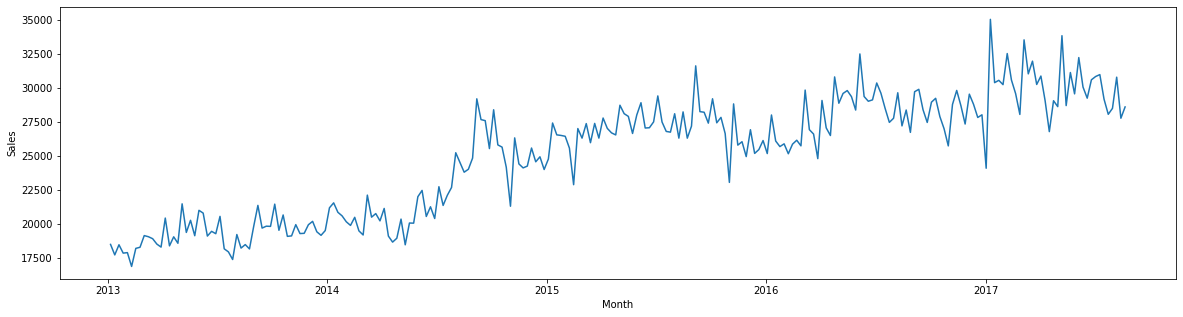

In [13]:
sample = bread_df['sales'].resample('W').mean()

plt.figure(figsize=(20,5))
plt.plot(sample)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

### Model

In [14]:
data = bread_df.sales.resample('W').mean()
T = 10
X = []
Y = []

for i in range(len(data)-T):
    x = data[i:i+T]
    X.append(x)
    y = data[i+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(232, 10)
(232,)


In [15]:
### Autoregressive LINEAR MODEL
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, callbacks

N = int(0.2 * len(X))
i = layers.Input(shape=(T,))
x = layers.Dense(1)(i)
model = Model(i, x)
model.compile(loss='mse', 
              optimizer=Adam(0.001), 
              metrics=['mae'])

early_stopping = callbacks.EarlyStopping(
    monitor ="val_loss", 
    mode ="min", 
    patience=5
)

# train the RNN
r = model.fit(X[:-N], Y[:-N], 
              epochs=200, 
              validation_data=(X[-N//2:], Y[-N//2:]), 
              callbacks=[early_stopping], shuffle=True)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

Epoch 1/200
6/6 [==============================] - 1s 37ms/step - loss: 981202240.0000 - mae: 30900.6191 - val_loss: 1457028096.0000 - val_mae: 38062.4258
Epoch 2/200
6/6 [==============================] - 0s 7ms/step - loss: 892217920.0000 - mae: 29464.4883 - val_loss: 1323120256.0000 - val_mae: 36260.7812
Epoch 3/200
6/6 [==============================] - 0s 10ms/step - loss: 808848640.0000 - mae: 28043.5000 - val_loss: 1196782336.0000 - val_mae: 34474.7500
Epoch 4/200
6/6 [==============================] - 0s 7ms/step - loss: 730607296.0000 - mae: 26640.2559 - val_loss: 1078421760.0000 - val_mae: 32713.1367
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - loss: 656674432.0000 - mae: 25253.4082 - val_loss: 968818944.0000 - val_mae: 30992.6875
Epoch 6/200
6/6 [==============================] - 0s 7ms/step - loss: 589559680.0000 - mae: 23907.9414 - val_loss: 867033152.0000 - val_mae: 29304.6035
Epoch 7/200
6/6 [==============================] - 0s 7ms/step - loss: 52618

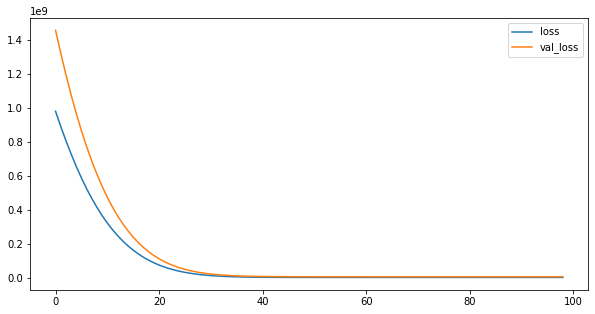

In [16]:
# Plot loss per iteration
plt.figure(figsize=(10,5))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(92, 1)


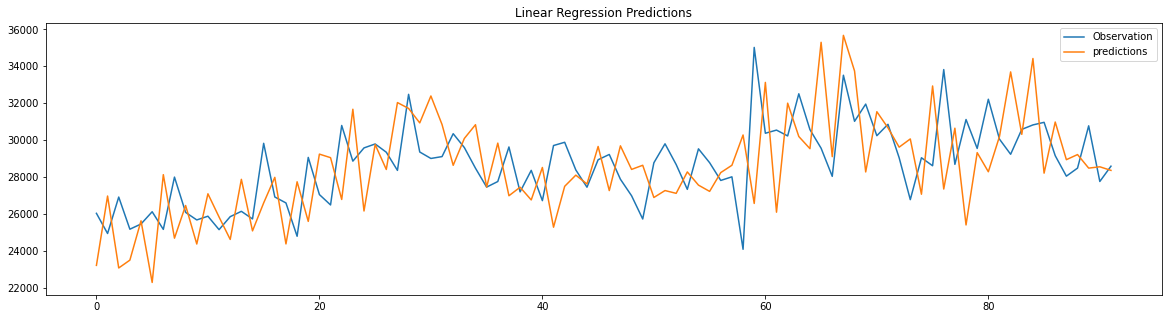

In [17]:
N = int(0.4 * len(X))
outputs = model.predict(X[-N:])
print(outputs.shape)
predictions = outputs[:,0]

plt.figure(figsize=(20,5))
plt.plot(Y[-N:], label='Observation')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()